In [2]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_scheduler
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset
# Load your dataset
column_names = ['tweet', 'emotion']
df = pd.read_csv('EmotionDataset06.csv',
                    names=column_names,
                    header=None)

# Convert emotions to numerical labels if they are not already
emotion_to_label = {'anger': 0, 'joy': 1, 'surprise': 2, 'disgust': 3, 'fear': 4, 'sad': 5}
df['emotion'] = df['emotion'].map(emotion_to_label)

# Split the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Load the model and tokenizer
# model_name = "aubmindlab/bert-base-arabert"
model_name = 'UBC-NLP/MARBERT'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

# Define training parameters
batch_size = 16
learning_rate = 2e-5
num_epochs = 3

# Tokenize and prepare datasets
train_encodings = tokenizer(train_df['tweet'].tolist(), truncation=True, padding=True, return_tensors="pt")
val_encodings = tokenizer(val_df['tweet'].tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test_df['tweet'].tolist(), truncation=True, padding=True, return_tensors="pt")

train_labels = torch.tensor(train_df['emotion'].tolist())
val_labels = torch.tensor(val_df['emotion'].tolist())
test_labels = torch.tensor(test_df['emotion'].tolist())

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, train_labels)
val_dataset = TensorDataset(val_encodings.input_ids, val_encodings.attention_mask, val_labels)
test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask, test_labels)

# Create data loaders
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

# Set up optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * num_epochs)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
val_accuracies = []


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [3]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Validation - Epoch {epoch + 1}"):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_val_preds.extend(preds)

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    val_accuracy = accuracy_score(val_labels, all_val_preds)
    val_accuracies.append(val_accuracy)

Validation - Epoch 3: 100%|██████████| 2835/2835 [02:56<00:00, 16.09it/s]


In [4]:
# Create data loader for the test set
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

Testing: 100%|██████████| 2835/2835 [03:00<00:00, 15.69it/s]


Test Accuracy: 0.9840811376915445
Test F1 Score: 0.9840823208693891


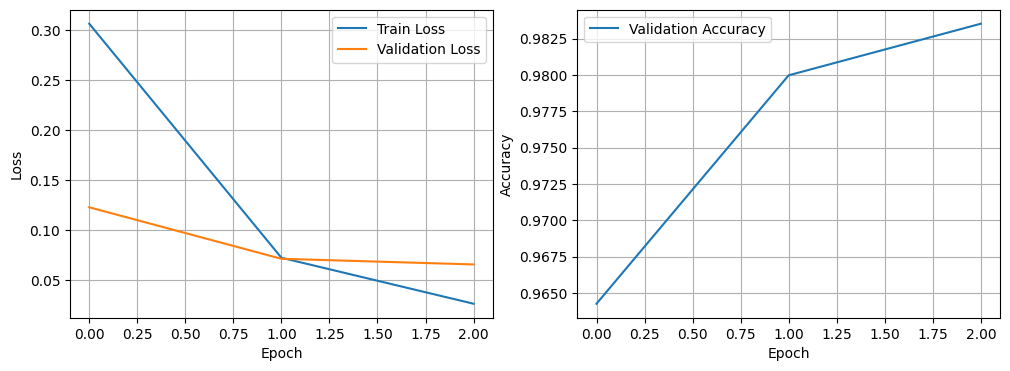

In [5]:
# Evaluation on the test set
model.eval()
test_loss = 0.0
all_test_preds = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        test_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_test_preds.extend(preds)

test_accuracy = accuracy_score(test_labels, all_test_preds)
test_f1_score = f1_score(test_labels, all_test_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 Score: {test_f1_score}")

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.show()

In [7]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ...

# Evaluation on the test set
model.eval()
test_loss = 0.0
all_test_preds = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        test_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_test_preds.extend(preds)

# Calculate overall accuracy and F1 score
test_accuracy = accuracy_score(test_labels, all_test_preds)
test_f1_score = f1_score(test_labels, all_test_preds, average='weighted')

print(f"Overall Test Accuracy: {test_accuracy}")
print(f"Overall Test F1 Score: {test_f1_score}")

# Calculate accuracy and F1 score for each emotion class
emotion_labels = ['anger', 'joy', 'surprise', 'disgust', 'fear', 'sad']
class_accuracies = {}

for emotion_label in emotion_labels:
    class_indices = test_df[test_df['emotion'] == emotion_label].index
    class_true_labels = test_labels[class_indices]
    class_preds = np.array(all_test_preds)[class_indices]
    class_accuracy = accuracy_score(class_true_labels, class_preds)
    class_f1_score = f1_score(class_true_labels, class_preds, average='weighted')
    class_accuracies[emotion_label] = class_accuracy

# Print accuracy and F1 score for each emotion class
for emotion_label, accuracy in class_accuracies.items():
    print(f"Test Accuracy for {emotion_label}: {accuracy}")

# Generate and print classification report
classification_rep = classification_report(test_labels, all_test_preds, target_names=emotion_labels)
print("\nClassification Report:\n", classification_rep)


Testing: 100%|██████████| 2835/2835 [03:00<00:00, 15.72it/s]
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/studio-lab-user/.con

Overall Test Accuracy: 0.9840811376915445
Overall Test F1 Score: 0.9840823208693891
Test Accuracy for anger: nan
Test Accuracy for joy: nan
Test Accuracy for surprise: nan
Test Accuracy for disgust: nan
Test Accuracy for fear: nan
Test Accuracy for sad: nan

Classification Report:
               precision    recall  f1-score   support

       anger       0.99      0.98      0.99     14089
         joy       0.99      0.99      0.99      7741
    surprise       0.98      0.98      0.98      5079
     disgust       0.98      0.98      0.98      4664
        fear       0.99      0.98      0.98      8938
         sad       0.98      0.99      0.98      4844

    accuracy                           0.98     45355
   macro avg       0.98      0.98      0.98     45355
weighted avg       0.98      0.98      0.98     45355



In [8]:
# Save the model
model_save_path = "./marbert/marbert_emotion_classifier"
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer_save_path = "./marbert/marbert_emotion_tokenizer"
tokenizer.save_pretrained(tokenizer_save_path)

('./marbert/marbert_emotion_tokenizer/tokenizer_config.json',
 './marbert/marbert_emotion_tokenizer/special_tokens_map.json',
 './marbert/marbert_emotion_tokenizer/vocab.txt',
 './marbert/marbert_emotion_tokenizer/added_tokens.json',
 './marbert/marbert_emotion_tokenizer/tokenizer.json')

In [9]:
model = AutoModelForSequenceClassification.from_pretrained("./marbert/marbert_emotion_classifier")
tokenizer = AutoTokenizer.from_pretrained("./marbert/marbert_emotion_tokenizer")

In [18]:
# def predict_emotion(tweet, model, tokenizer, label_dict):
#     model.eval()  # Set the model to evaluation mode
#     with torch.no_grad():  # No need to track gradients
#         # Explicitly specify max_length for truncation
#         inputs = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
#         outputs = model(**inputs)
#         predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Move logits to CPU and convert to numpy
#         predicted_label = [key for key, value in label_dict.items() if value == predictions[0]][0]
#     return predicted_label


# def predict_emotion(tweet, model, tokenizer, label_dict):
#     model.eval()  # Set the model to evaluation mode
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)  # Ensure the model is on the right device
#     with torch.no_grad():  # No need to track gradients
#         # Tokenize the tweet and ensure the tensors are moved to the same device as the model
#         inputs = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True, max_length=512)
#         inputs = {key: value.to(device) for key, value in inputs.items()}
#         outputs = model(**inputs)
#         predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Move logits to CPU and convert to numpy
#         predicted_label = [key for key, value in label_dict.items() if value == predictions[0]][0]
#     return predicted_label

def predict_emotion(tweet, model, tokenizer, label_dict):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure the model is on the right device
    with torch.no_grad():  # No need to track gradients
        # Tokenize the tweet and ensure the tensors are moved to the same device as the model
        inputs = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        outputs = model(**inputs)
        prediction_idx = torch.argmax(outputs.logits, dim=1).item()  # Get the predicted index
        predicted_label = label_dict.get(prediction_idx, "Unknown")  # Get the label from the dictionary
    return predicted_label


In [19]:
# Reverse the emotion_to_label dictionary
label_to_emotion = {v: k for k, v in emotion_to_label.items()}

# Predict the emotion of a sample tweet
sample_tweet = "كورونا خلصت علي الناس"
predicted_emotion = predict_emotion(sample_tweet, model, tokenizer, label_to_emotion)
print(f"Predicted emotion: {predicted_emotion}")



Predicted emotion: disgust


In [20]:
# Predict the emotion of a sample tweet
sample_tweet = "ناس كتير بتموت و مفيش مكان في المستشفيات"
predicted_emotion = predict_emotion(sample_tweet, model, tokenizer, label_to_emotion)
print(f"Predicted emotion: {predicted_emotion}")

Predicted emotion: disgust


In [21]:
# Predict the emotion of a sample tweet
sample_tweet = "الحمد لله النتجه سلبي و شفيت من كورونا"
predicted_emotion = predict_emotion(sample_tweet, model, tokenizer, label_to_emotion)
print(f"Predicted emotion: {predicted_emotion}")

Predicted emotion: anger


In [22]:

# Predict the emotion of a sample tweet
sample_tweet = "اشتقت للحياة قبل كورونا بدون خوف وفقد لنا نعرفهم وتباعد نروح وين مانبي بدون قلق"
predicted_emotion = predict_emotion(sample_tweet, model, tokenizer, label_to_emotion)
print(f"Predicted emotion: {predicted_emotion}")

Predicted emotion: fear
